{'levels': 8, 'alpha': 0.3}


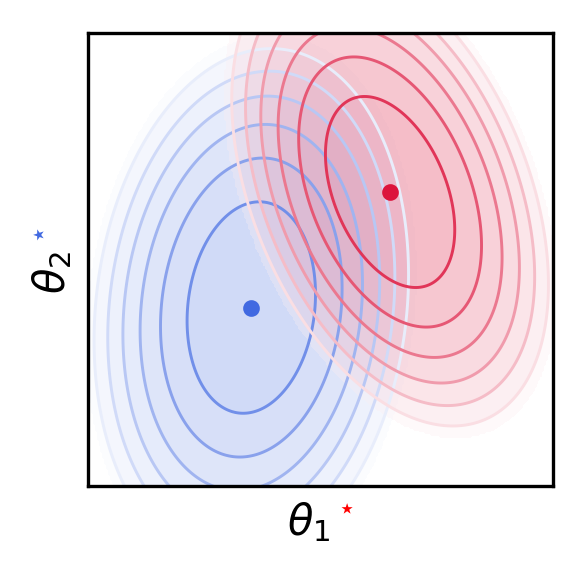

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import matplotlib.colors
from functools import lru_cache, wraps

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity='last_expr_or_assign'
init_printing()

np.set_printoptions(precision=2, suppress=True)

''' Usage: bc_arrow(x, fn) '''
def bc_arrow(x, fn, norm=3, size=5, color='white', frgnd='white', element=None, **pltargs):
    x = np.array(x).reshape(2)
    dx = np.array(fn(x), dtype=float).reshape(2)
    dx /= np.linalg.norm(dx)
    dx = dx*norm
    if element == 0: dx[1] = 0
    elif element == 1: dx[0] = 0

    line = plt.plot(*x, '.', color=frgnd, ms=4, **pltargs, zorder=10)[0]
    line.axes.annotate('',
        xytext=x,
        xy=x+dx,
        multialignment='right',
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )
    return line

def bc_arrow2(x, fn, mode='all', color='white', frgnd='white', **arrowargs):
    if not type(color) is list: color = [color]*2

    if mode=='all':
        bc_arrow(x, fn, **arrowargs, color=frgnd)
        bc_arrow(x, fn, **arrowargs, element=0, color=color[0], frgnd=frgnd)
        bc_arrow(x, fn, **arrowargs, element=1, color=color[1], frgnd=frgnd)
    elif mode=='perp':
        bc_arrow(x, fn, **arrowargs, element=0, color=color[0], frgnd=frgnd)
        bc_arrow(x, fn, **arrowargs, element=1, color=color[1], frgnd=frgnd)
    
''' Usage bc_coloredlabels(['k','red','blue'], ['$x$ ', '(red)'], ['$y$ ', '(blue)']) '''
def bc_coloredlabels(colors, xlabel, ylabel, frgnd="k"):
    from matplotlib.offsetbox import TextArea, AnchoredOffsetbox, VPacker, HPacker
    
    xbox1 = TextArea(xlabel[0], textprops=dict(color=frgnd, rotation=0,ha='left',va='bottom'))
    xbox2 = TextArea(xlabel[1], textprops=dict(color=colors[0], rotation=0,ha='left',va='bottom'))
    ybox2 = TextArea(ylabel[0], textprops=dict(color=frgnd, rotation=90,ha='left',va='bottom'))
    ybox1 = TextArea(ylabel[1], textprops=dict(color=colors[1], rotation=90,ha='left',va='bottom'))

    xbox = HPacker(children=[xbox1, xbox2],align="bottom", pad=0, sep=0)    
    ybox = VPacker(children=[ybox1, ybox2],align="bottom", pad=0, sep=0)


    anchored_xbox = AnchoredOffsetbox(loc=9, child=xbox, pad=0., frameon=False, bbox_to_anchor=(0.5, -0.05), 
                                      bbox_transform=plt.gca().transAxes, borderpad=0.)

    plt.gca().add_artist(anchored_xbox)
    


    anchored_ybox = AnchoredOffsetbox(loc=7, child=ybox, pad=0., frameon=False, bbox_to_anchor=(-0.03, 0.5), 
                                      bbox_transform=plt.gca().transAxes, borderpad=0.)

    plt.gca().add_artist(anchored_ybox)

bc_makelist = lambda x : [] if x is None else [x] if type(x) is not list else x

def quadratic_builder(Q1, Q2, z1, z2):
    
    def quad(z,Q,z0):
        x,y = z
        c = Q[0,0]*(x-z0[0])**2 + Q[1,0]*(x-z0[0])*(y-z0[0]) \
          + Q[1,1]*(y-z0[1])**2 + Q[0,1]*(x-z0[1])*(y-z0[1])
        return c

    def f(z):
        return quad(z, Q1, z1)

    def g(z):
        return quad(z, Q2, z2)
    
    return f, g

def plot(f, g, z0 = None, 
         plot_paretovectors = False, 
         plot_pareto = False,
         plot_nash = False, 
         plot_contour = True, 
         plot_vector = None, 
         plot_vectordecomp = 'all',
         plot_paths = None,
         dark = False):
    plot_paths = bc_makelist(plot_paths)
    
    fig = plt.figure(figsize=(2,2), dpi=300)
    ax = plt.gca()
    if dark: plt.style.use('dark_background')
    
    ax.set_xlim([-10,10])
    ax.set_ylim([-10,10])
    t = np.linspace(-10,10,250)
    X, Y = np.meshgrid(t, t)
    Z = np.vstack([X.ravel(), Y.ravel()])

    ''' Symbolic math '''
    z = symbols('x y')
    θ = symbols('θ')
    z = Matrix(z)
    x,y = z
    h = lambda z: θ*f(z) + (1-θ)*g(z)

    Df = Matrix([f(z).diff(x), f(z).diff(y)])
    Dg = Matrix([g(z).diff(x), g(z).diff(y)])
    Dh = [h(z).diff(x), h(z).diff(y)]

    ''' Solve for stationary points '''
    nash0 = z.subs(solve([Df[0], Dg[1]], z))
    fmin = z.subs(solve(Df, z))
    gmin = z.subs(solve(Dg, z))
    sol_pareto = solve(Dh, z)
    hmin = z.subs(sol_pareto)
    
    pareto = lambdify(θ, hmin)

    ''' Vector fields '''
    gameform = lambda v: [-Df[0].subs({x: v[0], y:v[1]}), -Dg[1].subs({x: v[0], y:v[1]})]
    fvec = lambda v: [-Df[0].subs({x: v[0], y:v[1]}), -Df[1].subs({x: v[0], y:v[1]})]
    gvec = lambda v: [-Dg[0].subs({x: v[0], y:v[1]}), -Dg[1].subs({x: v[0], y:v[1]})]    

    if plot_contour:
        # PARAMS: thresholds
        pltargs = {'levels': 8,
                  'alpha': .3}
        _l = 100    

        ff = f(Z).reshape(X.shape)
        gg = g(Z).reshape(X.shape)
        ff[ff>_l] = np.inf
        gg[gg>_l] = np.inf

        ''' Usage: plt.plot(x, y, **bc_linearcolor("red","green",(0,0,0,0))) '''
        bc_linearcolor = lambda *colors: dict(cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", [*colors]))

        print(pltargs)
        plt.contourf(X,Y,gg, **pltargs, **bc_linearcolor("royalblue", (0,0,0,0) if dark else (1,1,1,0)))
        plt.contourf(X,Y,ff, **pltargs, **bc_linearcolor("crimson", (0,0,0,0) if dark else (1,1,1,0)))
        
        pltargs = {'levels': 8,
                  'alpha': 1}
        plt.contour(X,Y,gg, linewidths=.7, **pltargs, **bc_linearcolor("royalblue", (0,0,0,0) if dark else (1,1,1,0)))
        plt.contour(X,Y,ff, linewidths=.7, **pltargs, **bc_linearcolor("crimson", (0,0,0,0) if dark else (1,1,1,0)))

        plt.plot(*fmin, '.', zorder=110, color="crimson")
        plt.plot(*gmin, '.', zorder=110, color="royalblue")

    if plot_pareto:
        t = 0.5
        emin = pareto(t)
        _t = np.linspace(1e-2, 1-1e-2,20)
        plt.plot(*pareto(_t)[:,0,:], ':w' if dark else ':k')
        plt.plot(*nash0, 'xw' if dark else 'xk')
    if plot_nash:
        plt.plot(*nash0, 'xw' if dark else 'xk')

    if plot_paretovectors:
        bc_arrow(emin, gameform, norm=5, element=0, color='red')
        bc_arrow(emin, gameform, norm=5, element=1, color='blue')
    
    if plot_vector=='gameform':
        bc_arrow2(z0, gameform, mode=plot_vectordecomp, color=['red','blue'], frgnd='white' if dark else 'black')
    elif plot_vector=='Df':
        bc_arrow2(z0, fvec, mode=plot_vectordecomp, color='red', frgnd='white' if dark else 'black')
    elif plot_vector=='Dg':
        bc_arrow2(z0, gvec, mode=plot_vectordecomp, color='blue', frgnd='white' if dark else 'black')
    
    for path, color in reversed(plot_paths):
        args = color.split()
        color = args[0]
        plt.plot(*path.T, 'w' if dark else 'k', zorder=100, lw=1, color=color)
        if 'smooth' not in args: 
            plt.plot(*path.T, '.w' if dark else '.k', zorder=101, ms=1, alpha=0.3)
        plt.plot(*path[-1].T, '.', zorder=100, ms=4, color=color)
        plt.scatter(*path[0].T, s=10, zorder=99, facecolors='none', edgecolors=color)
    

    plt.xticks([])
    plt.yticks([])
    bc_coloredlabels(('red','royalblue'), 
                     [r'$\theta_1$', '${}^\star$'], 
                     [r'$\theta_2$', '${}^\star$'], "w" if dark else "k")
    
Q1 = np.array([[2.3,.6],
               [.6,1]])
Q2 = np.array([[2,-.15],
               [-.15,.7]])

z1 = np.array([[3,3]]).T
z2 = np.array([[-3,-2]]).T
z0 = np.array([3, -6])

f, g = quadratic_builder(Q1, Q2, z1, z2)
plot(f,g)

In [35]:
import functools

def bc_descent(x0, lr, Dfunc, num_iter=int(1e3)):    
    x = np.zeros((num_iter, *x0.shape))
    x[0] = x0
    
    for k in range(num_iter-1):
        x[k+1] = x[k] - lr * Dfunc(x[k]).reshape(x0.shape)
    
    return x

z = symbols('x y')
x,y = z
θ = symbols('θ')

h = lambda z: θ*f(z) + (1-θ)*g(z) - log(θ**2) - log((1-θ)**2)

_Df = lambdify(z, Matrix([f(z).diff(x), f(z).diff(y)]), 'numpy')
_Dg = lambdify(z, Matrix([g(z).diff(x), g(z).diff(y)]), 'numpy')
_Dw = lambdify(z, Matrix([f(z).diff(x), g(z).diff(y)]), 'numpy')
_Dh = lambdify(symbols('x y θ'), Matrix([ h(z).diff(x), h(z).diff(y), h(z).diff(θ)]), 'numpy')

Df = lambda x: _Df(x[0], x[1]).T[0]
Dg = lambda x: _Dg(x[0], x[1]).T[0]
Dw = lambda x: _Dw(x[0], x[1]).T[0]
Dh = lambda x: _Dh(x[0],x[1],x[2]).T[0] * np.array([1,1,0.0])

z_fvec = bc_descent(z0, 0.35, Df, num_iter=int(1e3), )
z_gvec = bc_descent(z0, 0.35, Dg)
z_gameform = bc_descent(z0, 0.35, Dw)

z00 = np.block([z0,.5])
z_hvec = bc_descent(z00, 0.35, Dh)[:,:2]
z_htogameform = bc_descent(z_hvec[-1,:2], 0.35, Dw); None

import scipy as sp
import scipy.integrate

z_omegaint = sp.integrate.odeint(lambda z,t: -Dw(z), z0, np.arange(0,10,.1)); None

{'levels': 8, 'alpha': 0.3}


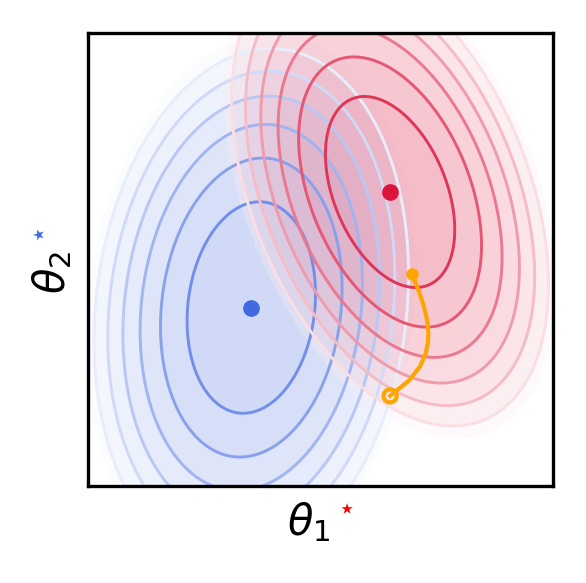

In [36]:
plot(f, g, z0, plot_paths=[(z_omegaint,'orange smooth')])

{'levels': 8, 'alpha': 0.3}


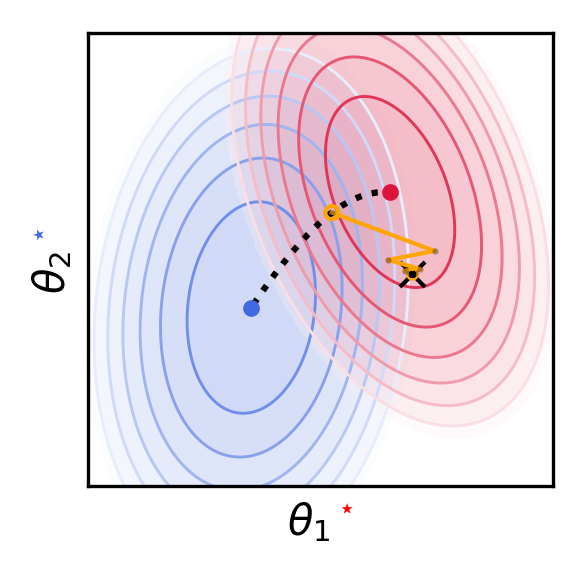

In [37]:
plot(f, g, z0, plot_pareto=True, plot_paths=[(z_htogameform, 'orange')])
plt.show()

{'levels': 8, 'alpha': 0.3}


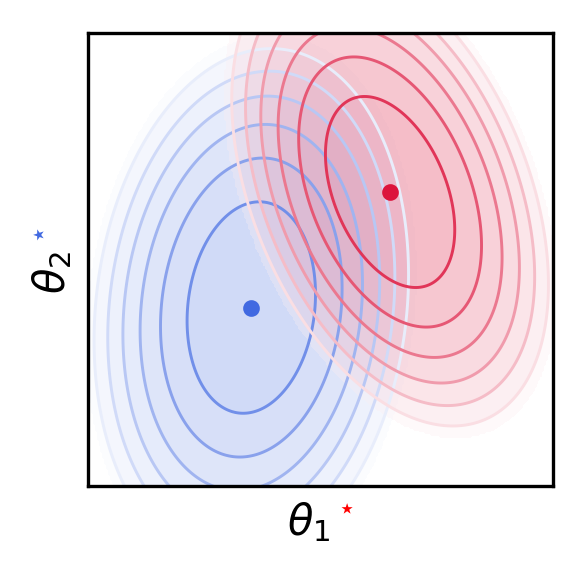

{'levels': 8, 'alpha': 0.3}


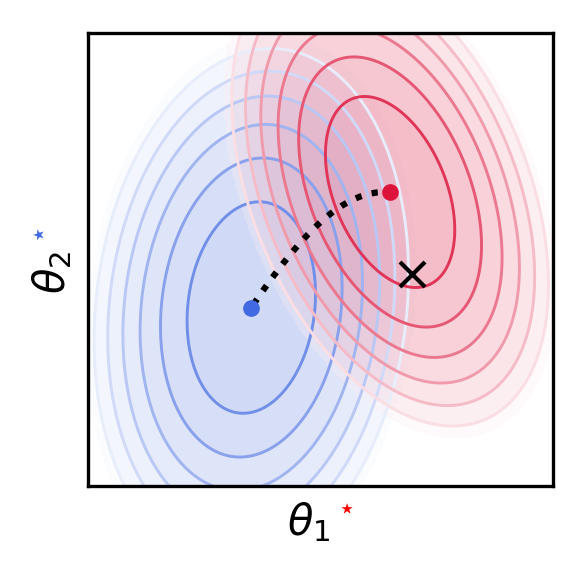

{'levels': 8, 'alpha': 0.3}


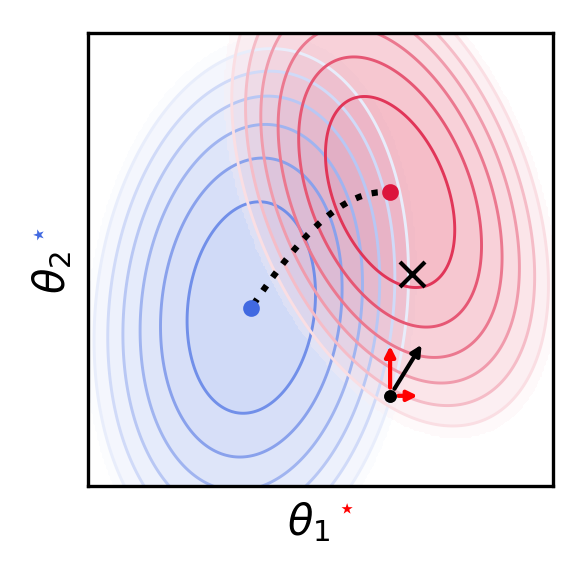

{'levels': 8, 'alpha': 0.3}


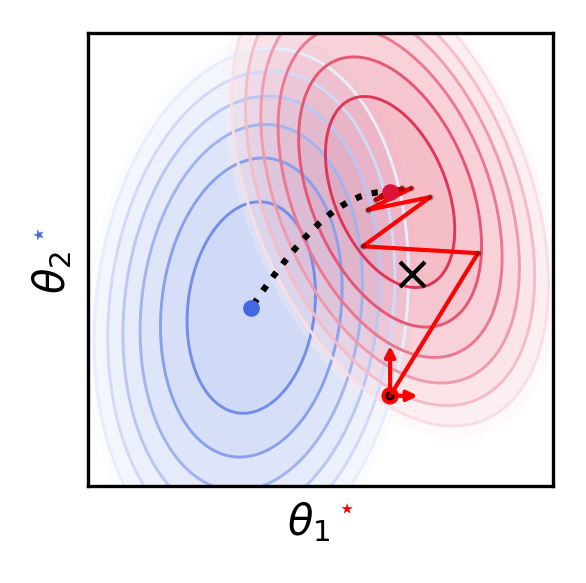

{'levels': 8, 'alpha': 0.3}


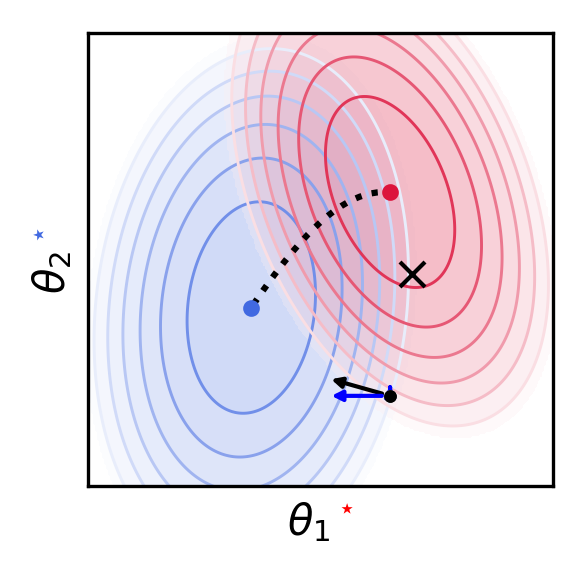

{'levels': 8, 'alpha': 0.3}


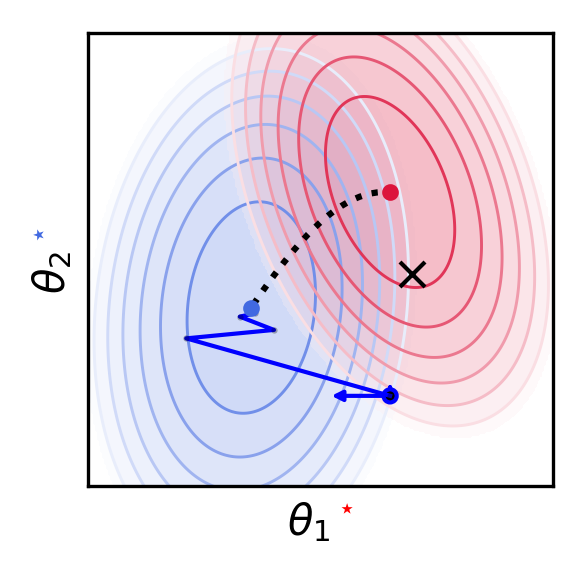

{'levels': 8, 'alpha': 0.3}


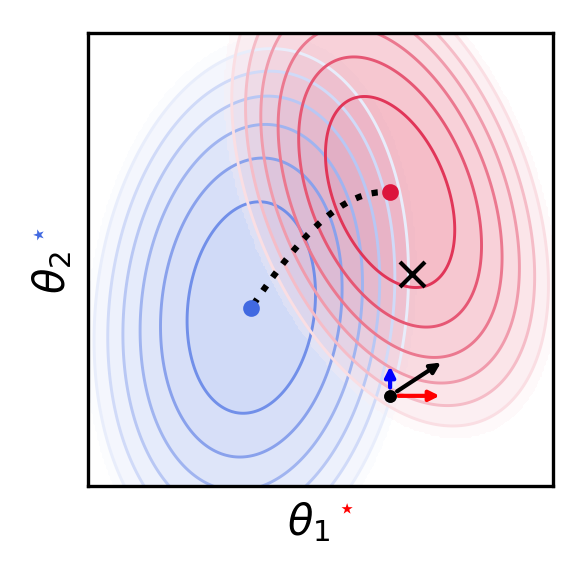

{'levels': 8, 'alpha': 0.3}


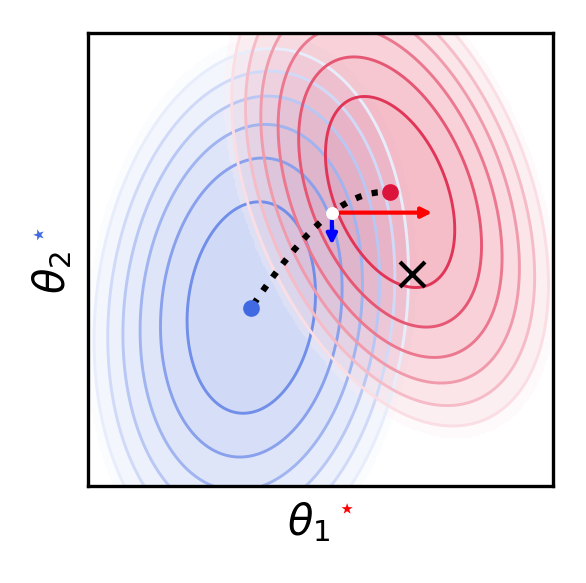

{'levels': 8, 'alpha': 0.3}


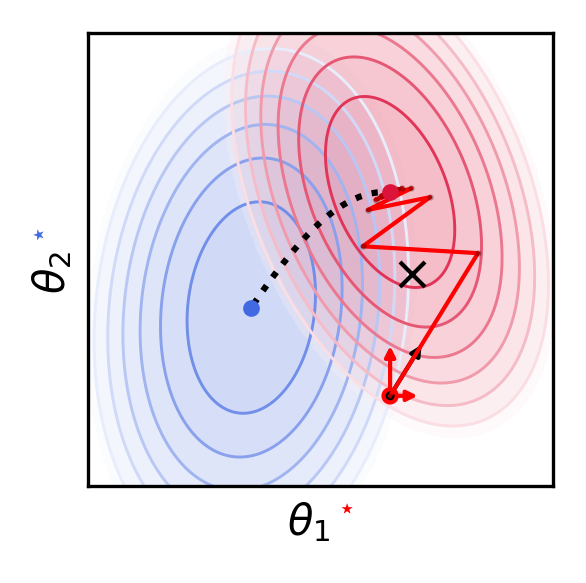

In [38]:

plot(f, g)
plt.show()

plot(f, g, plot_pareto=True)
plt.show()


plot(f, g, z0, plot_pareto=True, plot_vector='Df')
plt.show()

plot(f, g, z0, plot_pareto=True, plot_paths=(z_fvec, 'red'), plot_vector='Df', 
     plot_vectordecomp='perp')
plt.show()

plot(f, g, z0, plot_pareto=True, plot_vector='Dg')
plt.show()

plot(f, g, z0, plot_pareto=True, plot_paths=(z_gvec, 'blue'), plot_vector='Dg',
     plot_vectordecomp='perp')
plt.show()

plot(f, g, z0, plot_pareto=True, plot_vector='gameform')
plt.show()

plot(f, g, z0, plot_pareto=True, plot_paretovectors=True)
plt.show()

plot(f, g, z0, plot_pareto=True, plot_paths=(z_fvec, 'red'), plot_vector='Df')
plt.show()



{'levels': 8, 'alpha': 0.3}


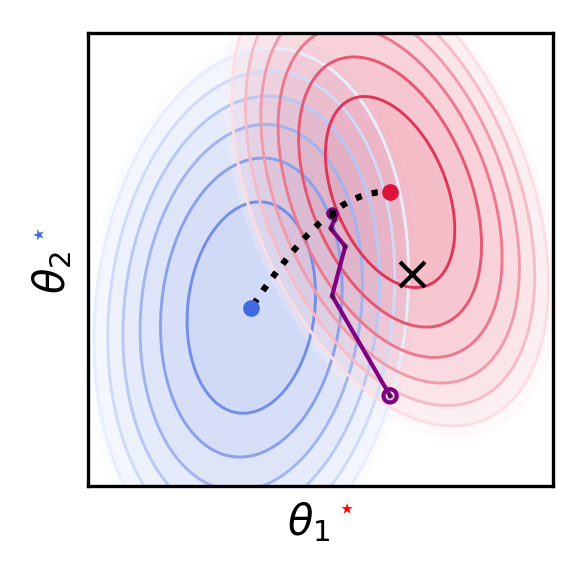

{'levels': 8, 'alpha': 0.3}


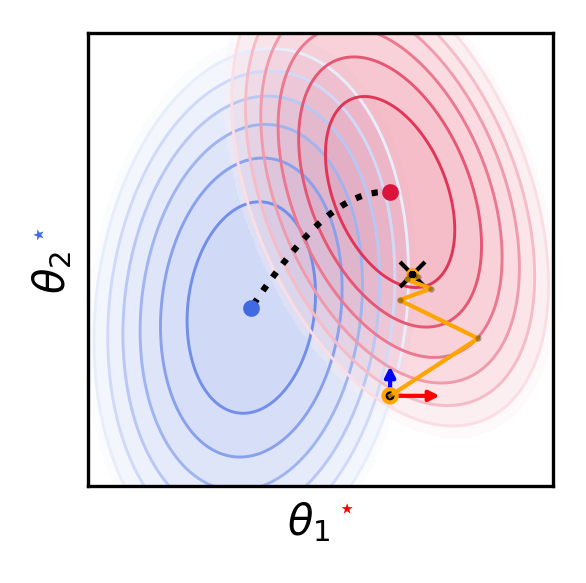

In [40]:
plot(f, g, z0, plot_pareto=True, plot_paths=(z_hvec, 'purple'), plot_vector='Dh',
     plot_vectordecomp='perp')
plt.show()

plot(f, g, z0, plot_pareto=True, plot_paths=(z_gameform, 'orange'), plot_vector='gameform',
     plot_vectordecomp='perp')
plt.show()

{'levels': 8, 'alpha': 0.3}


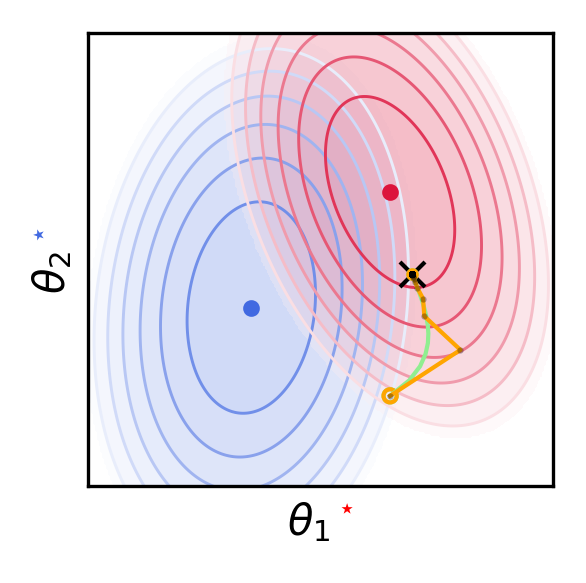

In [47]:
z_gameform = bc_descent(z0, 0.28, Dw)
plot(f, g, z0, plot_nash=True, plot_paths=[(z_gameform, 'orange'), (z_omegaint, 'lightgreen smooth')])
plt.show()

In [22]:
jacobian = np.array([[f(z).diff(x).diff(x), f(z).diff(x).diff(y)],[g(z).diff(y).diff(x), f(z).diff(y).diff(y)]], dtype=float)
S = 0.5*(jacobian.T + jacobian)
beta = np.max(np.sqrt(np.linalg.eigvals(jacobian.T @ jacobian)))

In [23]:
alpha=np.min(np.sqrt(np.linalg.eigvals(S.T @ S)))

{'levels': 8, 'alpha': 0.3}


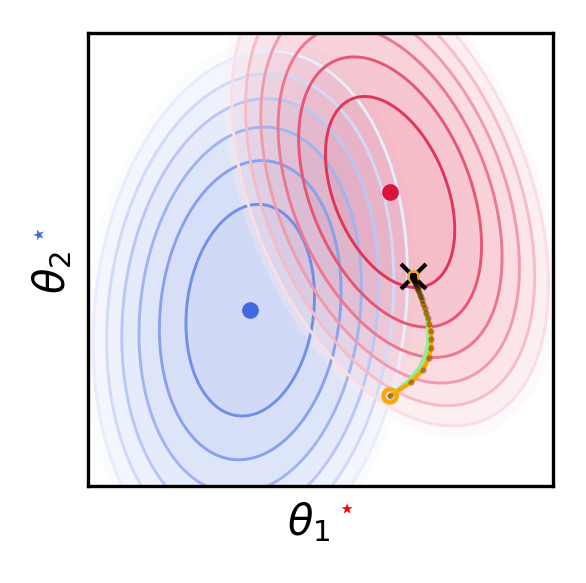

In [24]:
lr = alpha/beta**2
z_gameformopt = bc_descent(z0, lr, Dw)

plot(f, g, z0, plot_nash=True, plot_paths=[(z_gameformopt, 'orange'), (z_omegaint, 'lightgreen smooth')])
plt.show()

In [ ]:
plot(f, g, z0, plot_nash=True)
_t = np.linspace(0,2*np.pi,100)
_r = 2.5
circ = np.vstack([_r*np.sin(_t)+nash0[0], _r*np.cos(_t)+nash0[1]])
plt.plot(*circ,'--w',alpha=0.8, lw=1)

In [ ]:
np.linalg.eigvals(jacobian)

In [ ]:
nash0 = np.array(Matrix([x,y]).subs(solve([f(z).diff(x), g(z).diff(y)], z))).T[0]
nash0 = np.array(nash0, dtype=float)

In [ ]:
N = 100
thm = lambda k: np.exp(-(alpha/beta)**2/2*k)
_t = np.linspace(1,N,N)
plt.figure(figsize=(3,3*3/4), dpi=200)
normed = np.linalg.norm(z_gameformopt[:N]-nash0, axis=1)
plt.plot(_t, thm(_t)*normed[0],'--',color='white', alpha=0.8)
plt.plot(_t, normed, 'orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('distance to nash')
plt.ylim([6e-4,10])
# plt.grid()

In [ ]:
normed

In [ ]:
Q1 = np.array([[2.3,-2],
               [0,1]])
Q2 = np.array([[5,4],
               [-2,.7]])

z1 = np.array([[3,3]]).T
z2 = np.array([[-5,-2]]).T
z0 = np.array([3, -6])


f1, g1 = quadratic_builder(Q1, Q2, z1, z2)

_c = 1
def f1(z):
    x,y = z
    return (x-_c)**2 + 2*(y-_c)**2 + 5*(x-_c)*(y-_c) 

def g1(z):
    x,y = z
    return (x+_c)**2 + (y+_c)**2 - 5*(x+_c)*(y+_c)

z = symbols('x y')
x,y = z
_Dw = lambdify(z, Matrix([f1(z).diff(x), g1(z).diff(y)]), 'numpy')
Dw = lambda x: _Dw(x[0], x[1]).T[0]
z_gameform = bc_descent(z0, 0.05, Dw)

z_omegaint = sp.integrate.odeint(lambda z,t: -Dw(z), z0, np.arange(0,5,.01)); None

plot(f1, g1, z0, plot_nash=True, plot_paths=[(z_gameform, 'orange'), (z_omegaint, 'lightgreen smooth')])
plt.gca().relim()
plt.show()